### Daten erzeugen

X ist eine bivariate Gauss Verteilung.
y ist eine lineare Transformation der ersten Koordinate, mit Noise



In [1]:
import numpy as np

def generate_without_missing_values(n_samples, rng=42):
    mean = [0, 0]
    cov = [[1, 0.9], [0.9, 1]]
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)
    X = rng.multivariate_normal(mean, cov, size=n_samples)

    epsilon = 0.1 * rng.randn(n_samples)
    y = X[:, 0] + epsilon

    return X, y

### Plot der Daten

Jede Zeile von X gibt ein Punkt. y gibt die Färbung


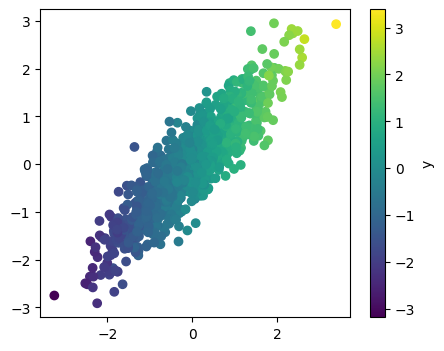

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4) # Smaller default figure size

plt.figure()
X_full, y_full = generate_without_missing_values(1000)
plt.scatter(X_full[:, 0], X_full[:, 1], c=y_full)
plt.colorbar(label='y')

### Missing completely at random 

Wir entfernen jetzt zufällig Daten


In [3]:
def generate_mcar(n_samples, missing_rate=.2, rng=42):
    X_full, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    M = rng.binomial(1, missing_rate, (n_samples, 2))
    X_mcar = X_full.copy()
    np.putmask(X_mcar, M, np.nan)

    return X_full, X_mcar, y

Plot der Daten mit missing values

Fehlende Werte sind grau.



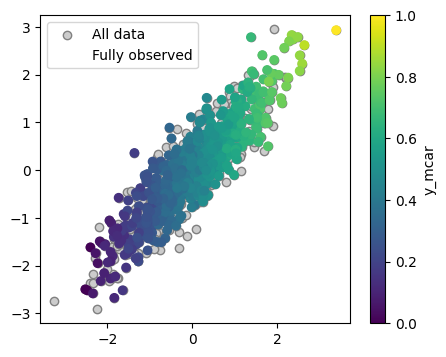

In [4]:
X_full, X_mcar, y_mcar = generate_mcar(1000)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y_mcar')
plt.scatter(X_mcar[:, 0], X_mcar[:, 1], c=y_mcar, label='Fully observed')
plt.legend()

### Not missing at random

Größere Werte fehlen eher als kleiner



In [5]:
def generate_censored(n_samples, missing_rate=.4, rng=42):
    X_full, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    B = rng.binomial(1, 2 * missing_rate, (n_samples, 2))
    M = (X_full > 0.5) * B
    
    X_nmar = X_full.copy()
    np.putmask(X_nmar, M, np.nan)

    return X_full, X_nmar, y

Wieder ein Plot


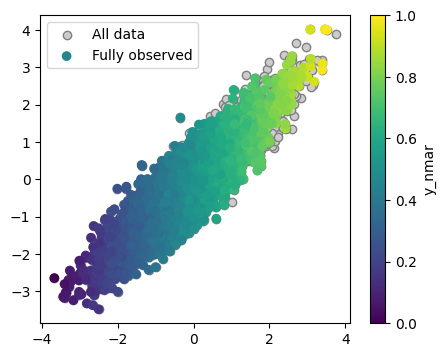

In [6]:
X_full, X_nmar, y_nmar = generate_censored(10000, missing_rate=.2)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data')
plt.colorbar(label='y_nmar')
plt.scatter(X_nmar[:, 0], X_nmar[:, 1], c=y_nmar, label='Fully observed')
plt.legend()

## Aufgaben

- MAR
    - Wandeln Sie die Funktion ```generate_mcar``` so ab, dass die Daten statt *missing completely at random* nur noch die Bedingung *missing at random* erfüllen.


- Auffüllen
    - Füllen Sie in beiden Fällen die Daten mit einem Iterativen Imputen auf
    - Füllen Sie in beiden Fällen die Daten mit einem SimpleImputer (z.Bsp. dem mean) auf
    - Visualisieren Sie die aufgefüllten Daten

- Modell trainieren
    - Trainieren Sie eine lineare Regression auf den aufgefüllten Daten und vergleichen Sie die Ergebnisse mit einer 10-fachen Kreuzvalidierung
    - Trainieren Sie zum Vergleich ein Modell mit ```HistGradientBoostingRegressor```. Dieses Modell kann mit fehlenden Werten umgehen.

- Mehr Daten
    - Erhöhen Sie die Datenmenge auf 10000 Punkte und vergleichen Sie wieder die Ergebnisse

```python
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
```



Missing at random 

In [7]:
def generate_mar(n_samples, missing_rate=.2, rng=42):
    X_full, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    #M = rng.binomial(1, missing_rate, (n_samples, 2))
    X_mar = X_full.copy()
    #np.putmask(X_mcar, M, np.nan)

    # Bedingung: Fehlen in der zweiten Spalte hängt von den Werten in der ersten Spalte ab
    mask = (X_full[:, 0] > np.mean(X_full[:, 0])) & (rng.rand(n_samples) < missing_rate)
    
    X_mar[mask, 1] = np.nan 
    
    return X_full, X_mar, y

In [8]:
# Visualisierung der Daten
def plot_data(X_full, X_imputed, y, title):
    plt.figure()
    plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
    plt.colorbar(label='y')
    plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y, label='Imputed data')
    plt.legend()
    plt.title(title)
    plt.show()

Auffüllen

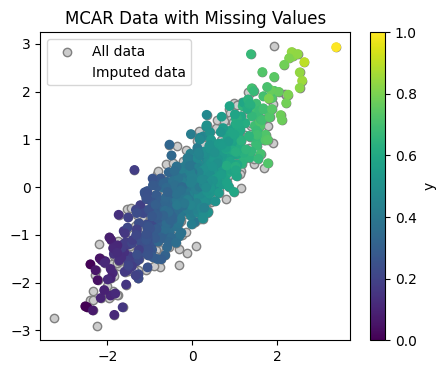

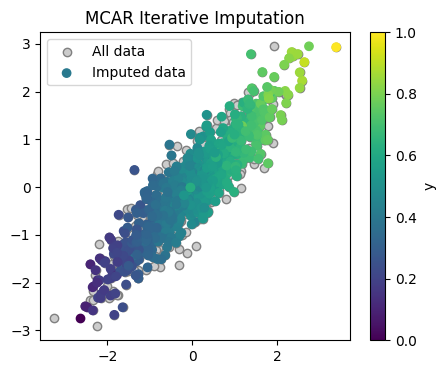

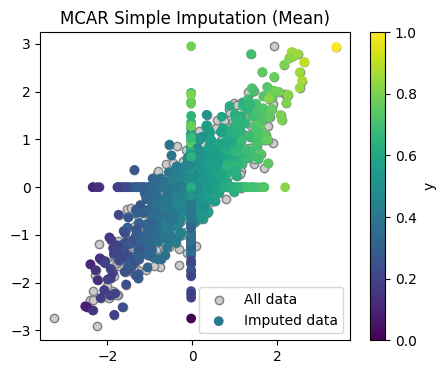

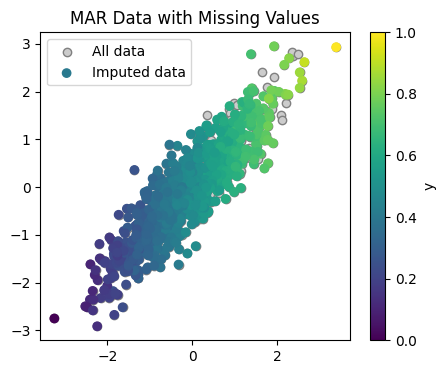

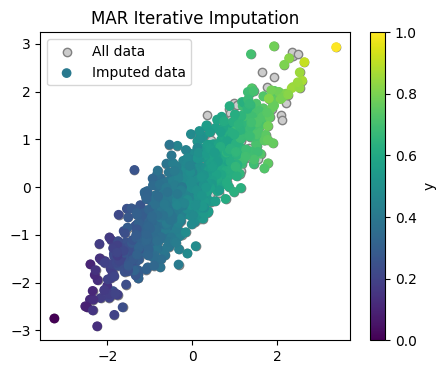

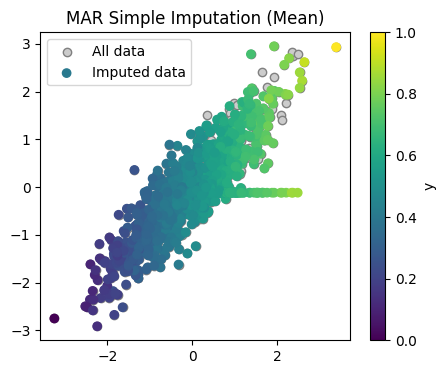

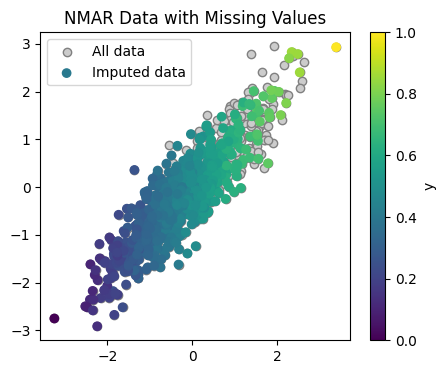

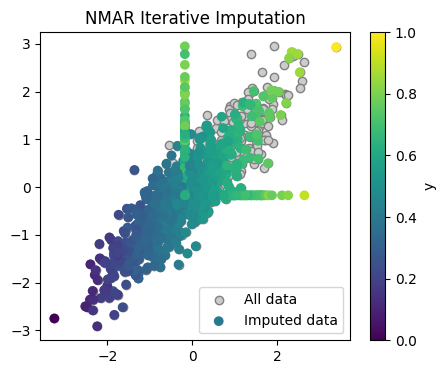

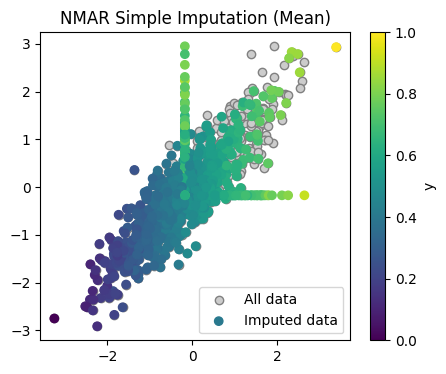

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Pipelines für die Imputation
iter_pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=0))
])

mean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Generieren von Daten
X_full, X_mcar, y_mcar = generate_mcar(1000)
X_full, X_mar, y_mar = generate_mar(1000)
X_full, X_nmar, y_nmar = generate_censored(1000, missing_rate=.2)

# Imputation durchführen
X_mcar_iter_imputed = iter_pipeline.fit_transform(X_mcar)
X_mar_iter_imputed = iter_pipeline.fit_transform(X_mar)
X_nmar_iter_imputed = mean_pipeline.fit_transform(X_nmar)

X_mcar_mean_imputed = mean_pipeline.fit_transform(X_mcar)
X_mar_mean_imputed = mean_pipeline.fit_transform(X_mar)
X_nmar_mean_imputed = mean_pipeline.fit_transform(X_nmar)

plot_data(X_full, X_mcar, y_mcar, 'MCAR Data with Missing Values')
plot_data(X_full, X_mcar_iter_imputed, y_mcar, 'MCAR Iterative Imputation')
plot_data(X_full, X_mcar_mean_imputed, y_mcar, 'MCAR Simple Imputation (Mean)')

plot_data(X_full, X_mar, y_mar, 'MAR Data with Missing Values')
plot_data(X_full, X_mar_iter_imputed, y_mar, 'MAR Iterative Imputation')
plot_data(X_full, X_mar_mean_imputed, y_mar, 'MAR Simple Imputation (Mean)')

plot_data(X_full, X_nmar, y_nmar, 'NMAR Data with Missing Values')
plot_data(X_full, X_nmar_iter_imputed, y_nmar, 'NMAR Iterative Imputation')
plot_data(X_full, X_nmar_mean_imputed, y_nmar, 'NMAR Simple Imputation (Mean)')

Model trainieren

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score


# Modelle trainieren und bewerten
def evaluate_model2(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, cv=cv)
    return scores.mean(), scores.std()*2

def evaluate_model(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, cv=cv)
    return scores
    

# Pipelines mit Modellen
lm_iter_pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=0)),
    ('model', LinearRegression())
])

lm_mean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', LinearRegression())
])


hist_gbr = HistGradientBoostingRegressor()

# Bewertung der Modelle
print("CMAR Iterative Imputed")
print(evaluate_model2(lm_iter_pipeline, X_mcar, y_mcar))
print("MAR Iterative Imputed")
print(evaluate_model2(lm_iter_pipeline, X_mar, y_mar))
print("NMAR Iterative Imputed")
print(evaluate_model2(lm_iter_pipeline, X_nmar, y_nmar))


print("CMAR Mean Imputed")
print(evaluate_model2(lm_mean_pipeline, X_mcar, y_mcar))
print("MAR Mean Imputed")
print(evaluate_model2(lm_mean_pipeline, X_mar, y_mar))
print("NMAR Mean Imputed")
print(evaluate_model2(lm_mean_pipeline, X_nmar, y_nmar))


print("CMAR direkt mit HistGradientBoosting")
print(evaluate_model2(hist_gbr, X_mcar, y_mcar))
print("MAR direkt mit HistGradientBoosting")
print(evaluate_model2(hist_gbr, X_mar, y_mar))
print("NMAR direkt mit HistGradientBoosting")
print(evaluate_model2(hist_gbr, X_nmar, y_nmar))

c:\Users\ryfy1\Desktop\DS_Master\FE\FE-Praktikum\.venv\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


CMAR Iterative Imputed
(0.9056625572914866, 0.05323226557749883)
MAR Iterative Imputed
(0.9893019368794566, 0.004582756423967799)
NMAR Iterative Imputed
(0.9233563714597057, 0.08314248225656373)
CMAR Mean Imputed
(0.8389337989075016, 0.06242706530026695)
MAR Mean Imputed
(0.9893004184201795, 0.004592696497252491)
NMAR Mean Imputed
(0.8439547653554506, 0.0874075204796747)
CMAR direkt mit HistGradientBoosting
(0.8967616664562701, 0.052625759001554744)
MAR direkt mit HistGradientBoosting
(0.9822256774515244, 0.00875533928118107)
NMAR direkt mit HistGradientBoosting
(0.9697669753663064, 0.020663880779340973)


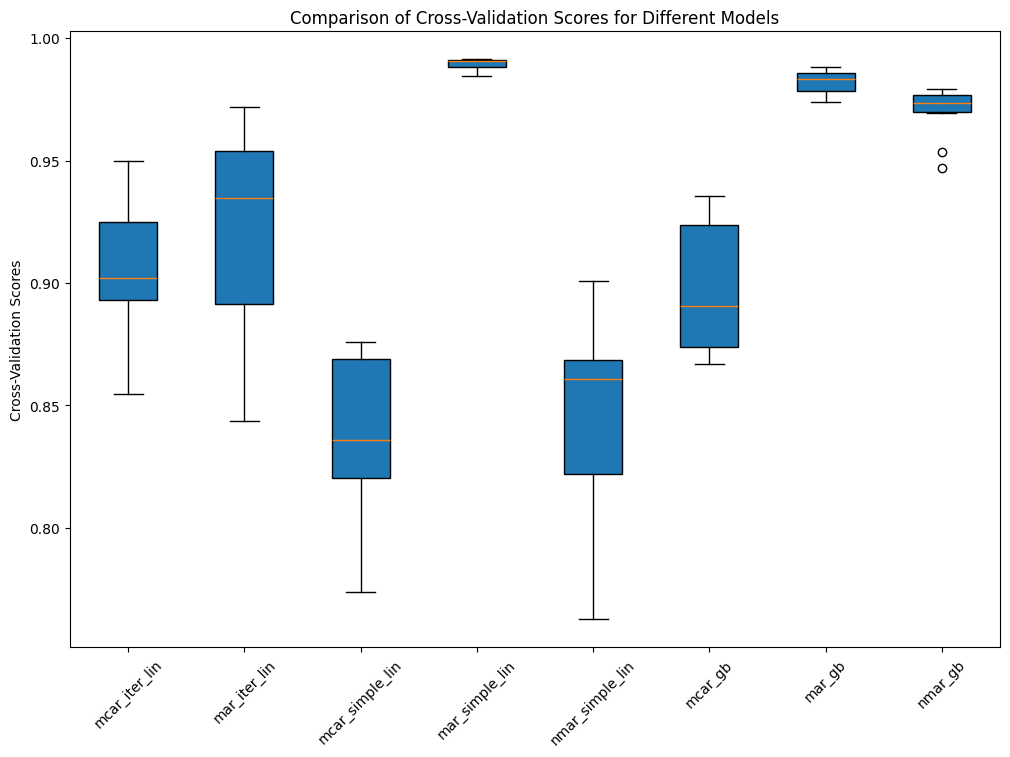

In [11]:
# Bewertung der Modelle
scores = {
    'mcar_iter_lin': evaluate_model(lm_iter_pipeline, X_mcar, y_mcar),
    'mar_iter_lin': evaluate_model(lm_iter_pipeline, X_mar, y_mar),
    'mar_iter_lin': evaluate_model(lm_iter_pipeline, X_nmar, y_nmar),
    'mcar_simple_lin': evaluate_model(lm_mean_pipeline, X_mcar, y_mcar),
    'mar_simple_lin': evaluate_model(lm_mean_pipeline, X_mar, y_mar),
    'nmar_simple_lin': evaluate_model(lm_mean_pipeline, X_nmar, y_nmar),
    'mcar_gb': evaluate_model(hist_gbr, X_mcar, y_mcar),
    'mar_gb': evaluate_model(hist_gbr, X_mar, y_mar),
    'nmar_gb': evaluate_model(hist_gbr, X_nmar, y_nmar)
    
}

# Boxplot erstellen
plt.figure(figsize=(12, 8))
plt.boxplot(scores.values(), labels=scores.keys(), patch_artist=True)
plt.xticks(rotation=45)
plt.ylabel('Cross-Validation Scores')
plt.title('Comparison of Cross-Validation Scores for Different Models')
plt.show()

Mit 10.000 Daten

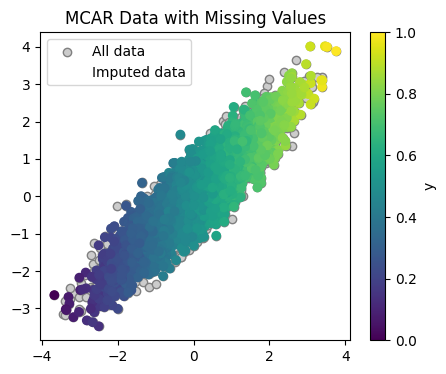

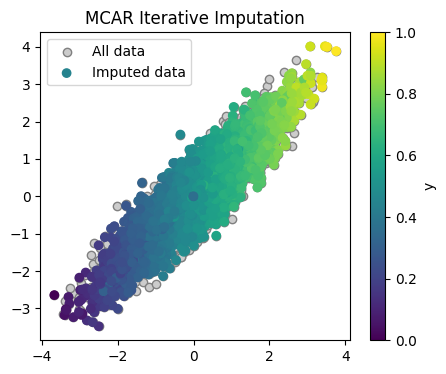

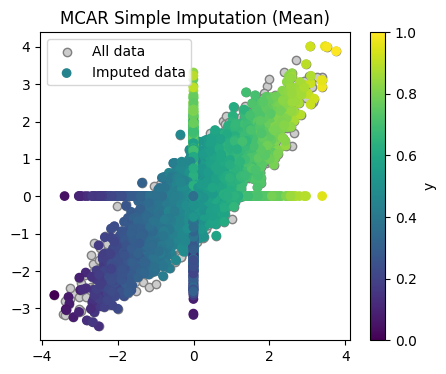

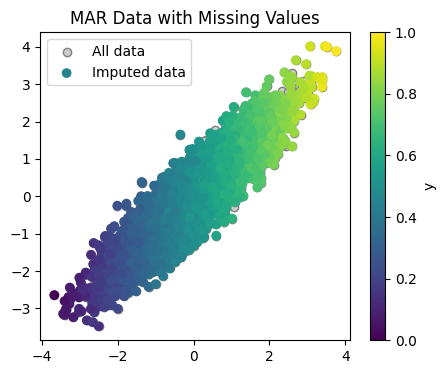

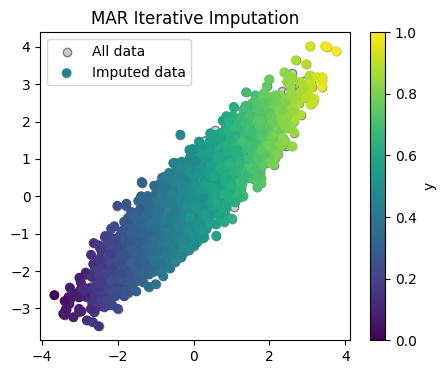

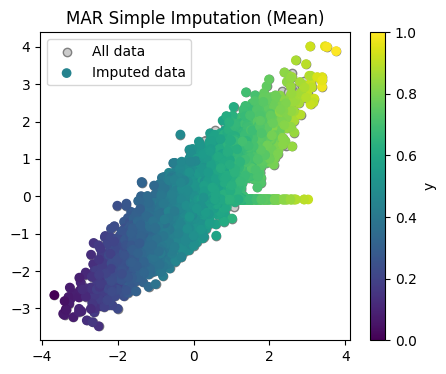

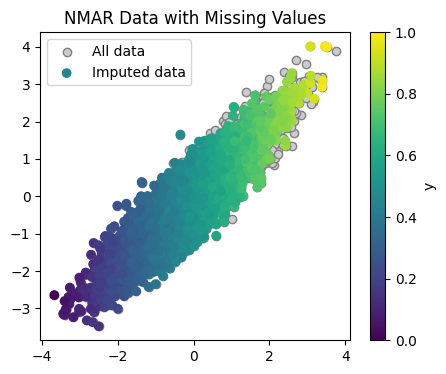

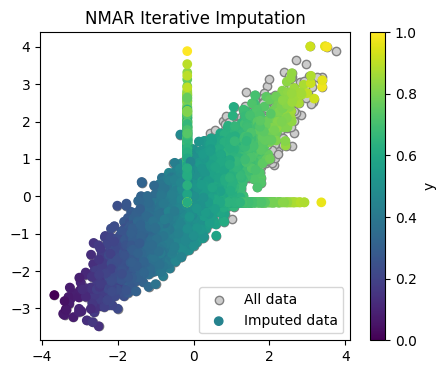

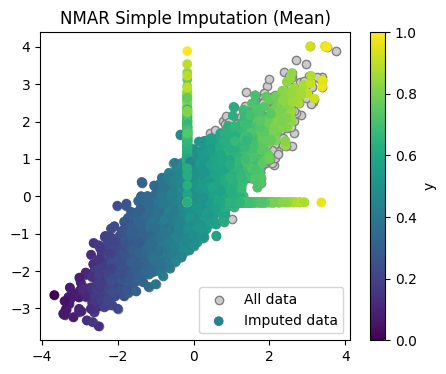

In [12]:
# Generieren von Daten, aber diesmal  mit 10.000
X_full, X_mcar, y_mcar = generate_mcar(10000)
X_full, X_mar, y_mar = generate_mar(10000)
X_full, X_nmar, y_nmar = generate_censored(10000, missing_rate=.2)

# Imputation durchführen
X_mcar_iter_imputed = iter_pipeline.fit_transform(X_mcar)
X_mar_iter_imputed = iter_pipeline.fit_transform(X_mar)
X_nmar_iter_imputed = mean_pipeline.fit_transform(X_nmar)

X_mcar_mean_imputed = mean_pipeline.fit_transform(X_mcar)
X_mar_mean_imputed = mean_pipeline.fit_transform(X_mar)
X_nmar_mean_imputed = mean_pipeline.fit_transform(X_nmar)

plot_data(X_full, X_mcar, y_mcar, 'MCAR Data with Missing Values')
plot_data(X_full, X_mcar_iter_imputed, y_mcar, 'MCAR Iterative Imputation')
plot_data(X_full, X_mcar_mean_imputed, y_mcar, 'MCAR Simple Imputation (Mean)')

plot_data(X_full, X_mar, y_mar, 'MAR Data with Missing Values')
plot_data(X_full, X_mar_iter_imputed, y_mar, 'MAR Iterative Imputation')
plot_data(X_full, X_mar_mean_imputed, y_mar, 'MAR Simple Imputation (Mean)')

plot_data(X_full, X_nmar, y_nmar, 'NMAR Data with Missing Values')
plot_data(X_full, X_nmar_iter_imputed, y_nmar, 'NMAR Iterative Imputation')
plot_data(X_full, X_nmar_mean_imputed, y_nmar, 'NMAR Simple Imputation (Mean)')

In [13]:
# Bewertung der Modelle
print("CMAR Iterative Imputed")
print(evaluate_model2(lm_iter_pipeline, X_mcar, y_mcar))
print("MAR Iterative Imputed")
print(evaluate_model2(lm_iter_pipeline, X_mar, y_mar))
print("NMAR Iterative Imputed")
print(evaluate_model2(lm_iter_pipeline, X_nmar, y_nmar))


print("CMAR Mean Imputed")
print(evaluate_model2(lm_mean_pipeline, X_mcar, y_mcar))
print("MAR Mean Imputed")
print(evaluate_model2(lm_mean_pipeline, X_mar, y_mar))
print("NMAR Mean Imputed")
print(evaluate_model2(lm_mean_pipeline, X_nmar, y_nmar))


print("CMAR direkt mit HistGradientBoosting")
print(evaluate_model2(hist_gbr, X_mcar, y_mcar))
print("MAR direkt mit HistGradientBoosting")
print(evaluate_model2(hist_gbr, X_mar, y_mar))
print("NMAR direkt mit HistGradientBoosting")
print(evaluate_model2(hist_gbr, X_nmar, y_nmar))

CMAR Iterative Imputed
(0.9229188550098432, 0.019106380906901563)
MAR Iterative Imputed
(0.990414428904152, 0.0012295984569624255)
NMAR Iterative Imputed
(0.8970792170355727, 0.03658466306873672)
CMAR Mean Imputed
(0.8417985916182724, 0.0222684676442433)
MAR Mean Imputed
(0.9904154224438658, 0.0012303419932515975)
NMAR Mean Imputed
(0.8241123041464027, 0.026134101988389957)
CMAR direkt mit HistGradientBoosting
(0.920295533213922, 0.019090391199941707)
MAR direkt mit HistGradientBoosting
(0.9892999275567691, 0.0009294246963545925)
NMAR direkt mit HistGradientBoosting
(0.9676105083988086, 0.006516469536213938)


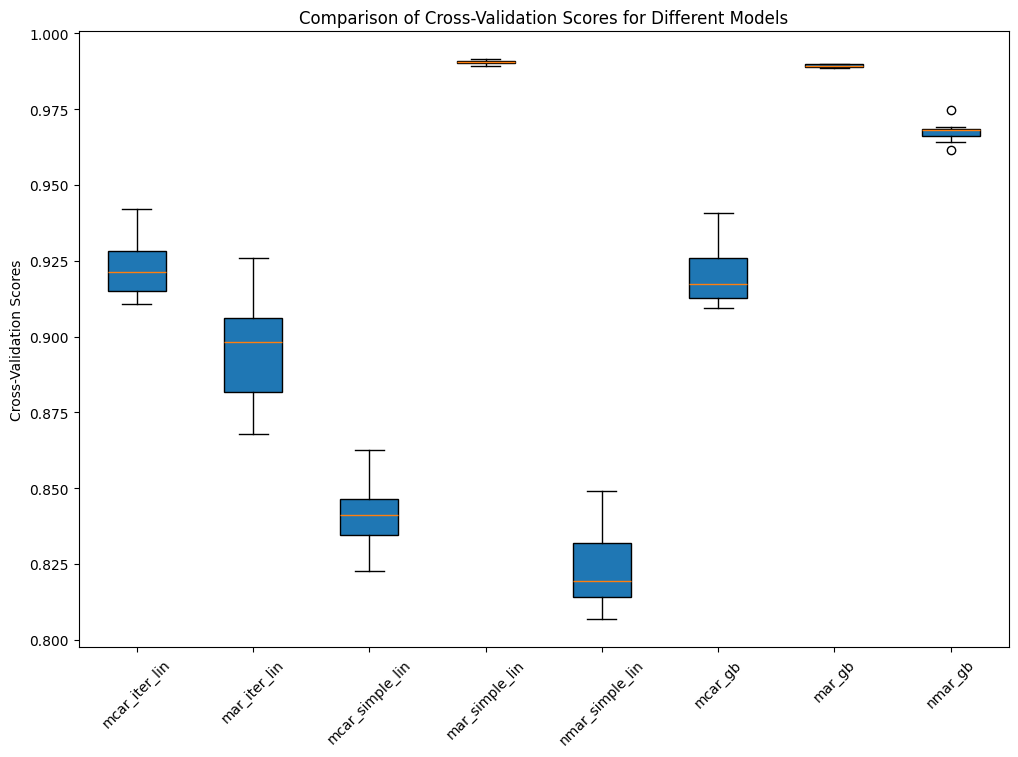

In [14]:
# Bewertung der Modelle
scores = {
    'mcar_iter_lin': evaluate_model(lm_iter_pipeline, X_mcar, y_mcar),
    'mar_iter_lin': evaluate_model(lm_iter_pipeline, X_mar, y_mar),
    'mar_iter_lin': evaluate_model(lm_iter_pipeline, X_nmar, y_nmar),
    'mcar_simple_lin': evaluate_model(lm_mean_pipeline, X_mcar, y_mcar),
    'mar_simple_lin': evaluate_model(lm_mean_pipeline, X_mar, y_mar),
    'nmar_simple_lin': evaluate_model(lm_mean_pipeline, X_nmar, y_nmar),
    'mcar_gb': evaluate_model(hist_gbr, X_mcar, y_mcar),
    'mar_gb': evaluate_model(hist_gbr, X_mar, y_mar),
    'nmar_gb': evaluate_model(hist_gbr, X_nmar, y_nmar)
    
}

# Boxplot erstellen
plt.figure(figsize=(12, 8))
plt.boxplot(scores.values(), labels=scores.keys(), patch_artist=True)
plt.xticks(rotation=45)
plt.ylabel('Cross-Validation Scores')
plt.title('Comparison of Cross-Validation Scores for Different Models')
plt.show()